# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

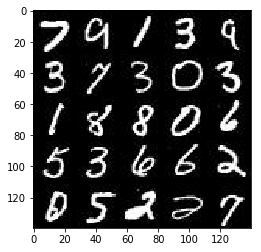

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

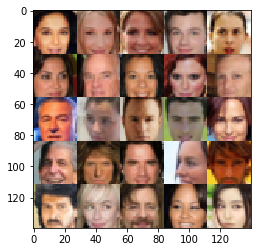

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    print(image_width, image_height, image_channels, z_dim)
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

28 28 3 100
Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid') #to adapt with image width 28
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    print(z_dim)
    data, image_width, image_height, image_channels= data_shape
    
    input_real, input_z, lr = model_inputs(
        image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
     # initalize data
    steps = 0
    print_every=10
    show_every=100
    losses = []
    num_images = 25
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, num_images, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
100
28 28 1 100
Epoch 1/2... Discriminator Loss: 0.2282... Generator Loss: 2.1524
Epoch 1/2... Discriminator Loss: 0.5371... Generator Loss: 5.2803
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 5.0568
Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 1.5156
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 0.4288... Generator Loss: 2.7422
Epoch 1/2... Discriminator Loss: 0.2904... Generator Loss: 1.6116
Epoch 1/2... Discriminator Loss: 0.0784... Generator Loss: 4.3112
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 1.6867... Generator Loss: 11.4417


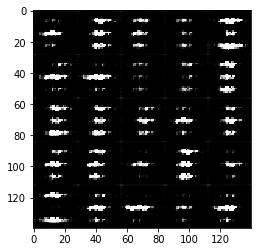

Epoch 1/2... Discriminator Loss: 0.5189... Generator Loss: 1.5973
Epoch 1/2... Discriminator Loss: 0.3496... Generator Loss: 1.5730
Epoch 1/2... Discriminator Loss: 0.3166... Generator Loss: 2.4150
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 2.0783
Epoch 1/2... Discriminator Loss: 0.3389... Generator Loss: 2.0407
Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 1.7397
Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 0.1875... Generator Loss: 2.9191
Epoch 1/2... Discriminator Loss: 0.4474... Generator Loss: 1.4625
Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 2.4261


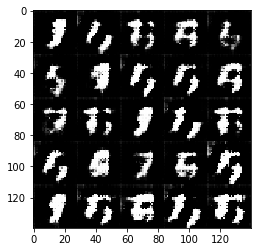

Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 3.2121
Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 3.6912
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 3.7283
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 3.5583
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 3.4720
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 0.5310... Generator Loss: 2.7876
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 4.4020
Epoch 1/2... Discriminator Loss: 0.7659... Generator Loss: 3.2369
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 1.0080


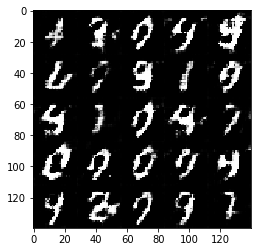

Epoch 1/2... Discriminator Loss: 0.3214... Generator Loss: 2.8888
Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 2.4921
Epoch 1/2... Discriminator Loss: 0.3523... Generator Loss: 2.8031
Epoch 1/2... Discriminator Loss: 0.6117... Generator Loss: 1.7747
Epoch 1/2... Discriminator Loss: 0.5354... Generator Loss: 1.4206
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.2638
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.7661


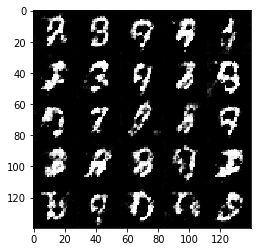

Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 1.0518
Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 2.2777
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 1.7119
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.6021
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 1.1493
Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 1.1255
Epoch 2/2... Discriminator Loss: 1.7664... Generator Loss: 3.5437
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 2.5108


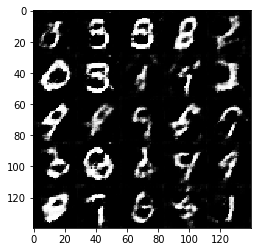

Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.6598
Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 1.9766
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 2.3321
Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 1.4379
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 2.1245
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.2695
Epoch 2/2... Discriminator Loss: 0.6464... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.4809
Epoch 2/2... Discriminator Loss: 0.6717... Generator Loss: 2.0533


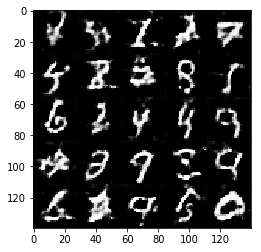

Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.6218
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 2.3994
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.7329
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 0.7182
Epoch 2/2... Discriminator Loss: 0.8979... Generator Loss: 1.1632
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.9022
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 2.2564
Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 1.5623


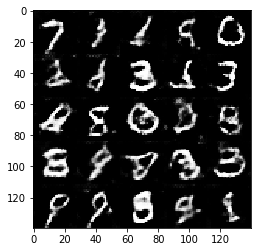

Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 1.1933
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.3534
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.1629... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 1.3762
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 1.6533
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.6111... Generator Loss: 0.3473
Epoch 2/2... Discriminator Loss: 1.0870... Generator Loss: 2.1049


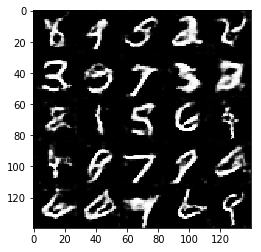

Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 0.9156... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.2817
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.2855
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 0.9281... Generator Loss: 1.0189
Epoch 2/2... Discriminator Loss: 1.6042... Generator Loss: 3.5560
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.8821


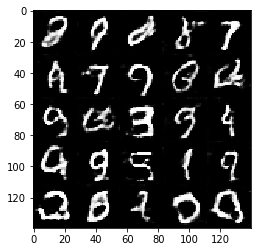

Epoch 2/2... Discriminator Loss: 1.3178... Generator Loss: 0.4877
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 3.7116... Generator Loss: 0.0478


In [12]:
batch_size = 128
z_dim = 100
learning_rate = .002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
100
28 28 3 100
Epoch 1/1... Discriminator Loss: 1.7510... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 0.3321... Generator Loss: 5.4703
Epoch 1/1... Discriminator Loss: 0.1773... Generator Loss: 2.2435
Epoch 1/1... Discriminator Loss: 1.9515... Generator Loss: 9.3683
Epoch 1/1... Discriminator Loss: 2.7175... Generator Loss: 0.2184
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 2.7720
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 0.2899... Generator Loss: 3.9529
Epoch 1/1... Discriminator Loss: 0.2261... Generator Loss: 2.4190


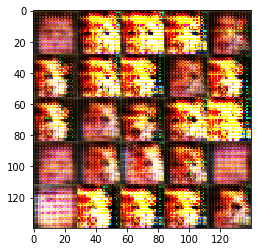

Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 5.3748
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.8250
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 1.7648
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 4.1056
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 1.5451
Epoch 1/1... Discriminator Loss: 1.8322... Generator Loss: 4.3211
Epoch 1/1... Discriminator Loss: 0.2365... Generator Loss: 2.3846
Epoch 1/1... Discriminator Loss: 2.2729... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 2.6974


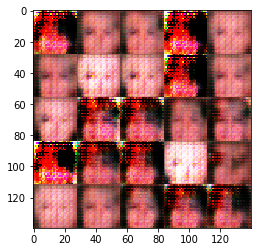

Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 4.2562
Epoch 1/1... Discriminator Loss: 2.5784... Generator Loss: 4.0585
Epoch 1/1... Discriminator Loss: 2.4078... Generator Loss: 0.1659
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 3.8296
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 3.9542
Epoch 1/1... Discriminator Loss: 1.8198... Generator Loss: 0.9424


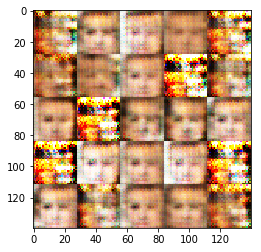

Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 1.4396
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.5944
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.6687... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.7304... Generator Loss: 0.2613
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 0.7517


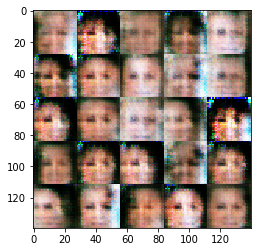

Epoch 1/1... Discriminator Loss: 1.8287... Generator Loss: 2.1272
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.3485
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.8169... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.7280


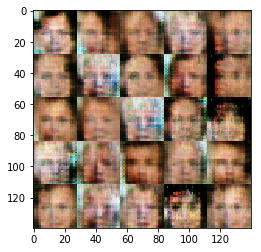

Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 3.0043... Generator Loss: 0.0673
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 2.0981
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.3441
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.8831
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.3594


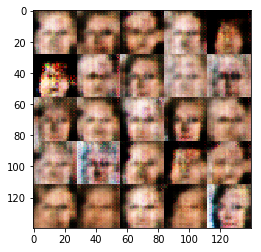

Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 2.1884
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 2.0873
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.5787
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 1.9535
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.1944


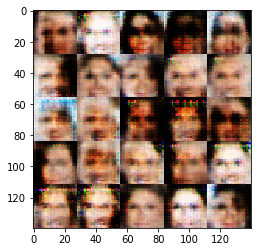

Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.6426


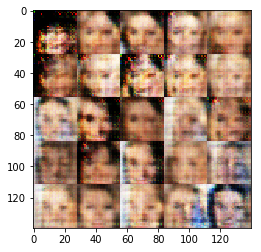

Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 1.6293... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 2.2546... Generator Loss: 2.5795
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 2.1342
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 2.0265
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.4385


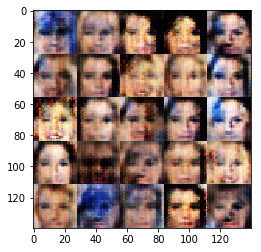

Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 3.2962
Epoch 1/1... Discriminator Loss: 2.5802... Generator Loss: 3.6221
Epoch 1/1... Discriminator Loss: 2.3408... Generator Loss: 3.2159
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 0.5925... Generator Loss: 1.9534
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.8506


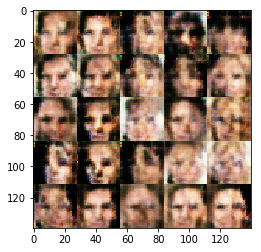

Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.3602
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 3.1319... Generator Loss: 0.1407
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 1.9708
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.7215


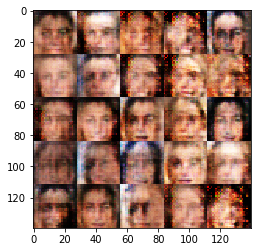

Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 1.8499
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.4060
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6298


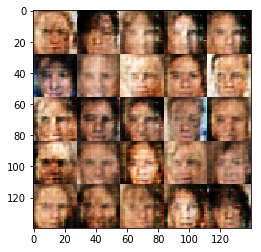

Epoch 1/1... Discriminator Loss: 1.8703... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 1.7492
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 1.8530


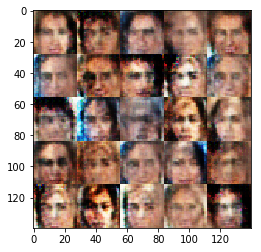

Epoch 1/1... Discriminator Loss: 2.3562... Generator Loss: 0.1628
Epoch 1/1... Discriminator Loss: 2.1555... Generator Loss: 2.0884
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 1.3986
Epoch 1/1... Discriminator Loss: 2.1012... Generator Loss: 2.6363
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.7299
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.8890


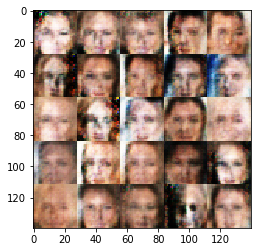

Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 2.7108
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 3.7484... Generator Loss: 4.1742
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.4957
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.8295


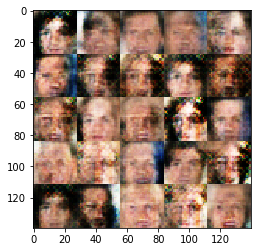

Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 1.9322
Epoch 1/1... Discriminator Loss: 1.7271... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 2.0619
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.1445


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.